In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
from collections import OrderedDict 

import sys
import paths
sys.path.append(paths.scripts_root)
import util

%load_ext autoreload
%autoreload 2

# Display entire width of browser
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

print("Paths:")
for k,v in paths.path.items():
    print(" path.%s: %s" % (k,v))

Paths:
 path.images_root: /Users/trafferty/data/images
 path.ws_dir: /Users/trafferty/workspace
 path.results_root: /Users/trafferty/data/results
 path.notebook_root: /Users/trafferty/data/notebooks
 path.tmp_dir: /Users/trafferty/tmp
 path.projects_root: /Users/trafferty/data/projects
 path.scripts_root: /Users/trafferty/data/scripts
 path.tmp_root: /Users/trafferty/data/tmp


In [2]:
# Scale 16-bit image to 8-bit
def convert16BitTo8Bit(img16):
    # Scale ref to 8-bit
    minLevel = np.min(np.min(img16))
    img8 = (img16.copy() - minLevel);
    maxLevel = np.max(np.max(img8))
    img8 = (img8*255.0/maxLevel).astype(np.uint8)
    return img8


In [3]:
def variance_of_laplacian(img):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(img, cv2.CV_64F).var()


In [4]:
imgs = OrderedDict()
imgs["+0"  ] = paths.images_root+'/dif/focus/+0/2017-09-29_09.22.41/DispenserOpt_00005_2017-09-29_09.22.52.png'
#imgs["+100"] = paths.images_root+'/dif/focus/+100um/2017-09-29_09.24.18/DispenserOpt_00005_2017-09-29_09.24.30.png'
imgs["+10" ] = paths.images_root+'/dif/focus/+10um/2017-09-29_09.23.27/DispenserOpt_00005_2017-09-29_09.23.38.png'
imgs["+20" ] = paths.images_root+'/dif/focus/+20um/2017-09-29_09.25.05/DispenserOpt_00005_2017-09-29_09.25.15.png'
imgs["+30" ] = paths.images_root+'/dif/focus/+30um/2017-09-29_09.25.38/DispenserOpt_00005_2017-09-29_09.25.49.png'
imgs["+40" ] = paths.images_root+'/dif/focus/+40um/2017-09-29_09.26.13/DispenserOpt_00005_2017-09-29_09.26.24.png'
imgs["-10" ] = paths.images_root+'/dif/focus/-10um/2017-09-29_09.28.59/DispenserOpt_00005_2017-09-29_09.29.09.png'
imgs["-20" ] = paths.images_root+'/dif/focus/-20um/2017-09-29_09.29.44/DispenserOpt_00005_2017-09-29_09.29.54.png'
imgs["-30" ] = paths.images_root+'/dif/focus/-30um/2017-09-29_09.31.29/DispenserOpt_00005_2017-09-29_09.31.39.png'
imgs["-40" ] = paths.images_root+'/dif/focus/-40um/2017-09-29_09.32.16/DispenserOpt_00005_2017-09-29_09.32.27.png'


In [6]:
def findBLOBs(img):
    # Setup SimpleBlobDetector parameters.
    params = cv2.SimpleBlobDetector_Params()

    # Change thresholds
    params.minThreshold = 100;
    params.maxThreshold = 150;

    # Filter by Circularity
    params.filterByCircularity = False
    params.minCircularity = .8

    # # Filter by Convexity
    params.filterByConvexity = False
    # params.minConvexity = 0.87

    # # Filter by Inertia
    params.filterByInertia = False
    # params.minInertiaRatio = 0.9

    params.filterByColor = False
    params.filterByArea = True
#     params.minArea = 4 * np.pi
#     params.maxArea = 100 * np.pi
    params.minArea = 20
    params.maxArea = 500

    detector = cv2.SimpleBlobDetector_create(params)
    #detector = cv2.SimpleBlobDetector_create()

    # Detect blobs.
    keypoints = detector.detect(img)
    return keypoints

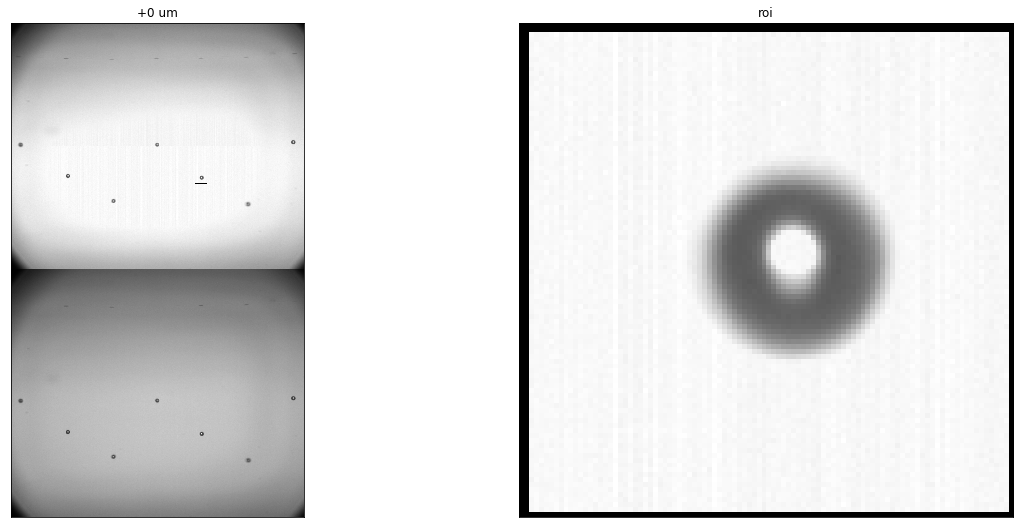

In [5]:
k = "+0"
img16 = cv2.imread(imgs[k],cv2.IMREAD_ANYDEPTH)
img16.dtype
img8 = convert16BitTo8Bit(img16)

h,w = 100, 100
sx = 1610
sy = 1310
roi = img16[sy:sy+h, sx:sx+w]  #np slice: [startY:endY, startX:endX]
cv2.rectangle(img16, (sx, sy), (sx+w, sy+h), (0,0,0), 2) # two corners: (startX, startY), (endX, endY)

util.plot_imgs([(convert16BitTo8Bit(img16), "%s um" % (k)), (convert16BitTo8Bit(roi), "roi")])

In [35]:
def findROI(img8, num_cols, coi, tag="", debug=True):
    plot_list = []
    plot_list.append( (img8,'roi:%s'%tag) )
    
    rows,cols = img8.shape
    col_width = int(cols/num_cols)

    h,w = rows, col_width
    sx = int(col_width * coi)
    col_img = img8[0:rows, sx:sx+col_width]  #np slice: [startY:endY, startX:endX]
    #if debug: plot_list.append((col_img, "nozzle on col# %d" %(coi+1)))

    keypoints = findBLOBs(col_img)
    if debug: print( "[findROI] num keypoints found: ", len(keypoints))

    if len(keypoints):
        # Draw detected blobs as red circles.
        # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
        #roi_with_keypoints = cv2.drawKeypoints(roi, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        kp = keypoints[0]
        x, y, dia = int(kp.pt[0]), int(kp.pt[1]), int(kp.size)
        if debug: print("[findROI] (%d, %d), dia: %d, area: %f" % (x, y, dia, np.pi*dia))

        roi = col_img.copy()[y-75:y+75, 1:col_width]

        if debug:
#             plot_list.append( (roi,'roi:%s'%tag) )
            cv2.circle(col_img, (x, y), int(dia/2), (0,0,255),2)
            cv2.line(col_img, (x, y-dia), (x, y+dia), (0,0,255), 3)
            cv2.line(col_img, (x-dia, y), (x+dia, y), (0,0,255), 3)
            #plot_list.append( (col_img,'Keypoints') )
        #cv2.rectangle(img8, (sx, sy), (sx+w, sy+h), (0,0,0), 10) # two corners: (startX, startY), (endX, endY)                

    if debug:
        util.plot_imgs(plot_list)
    
    if len(keypoints):
        return roi
    else:
        return None

[findROI] num keypoints found:  2
[findROI] (182, 531), dia: 10, area: 31.415927


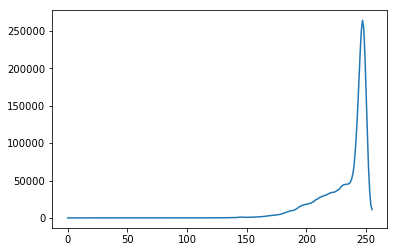

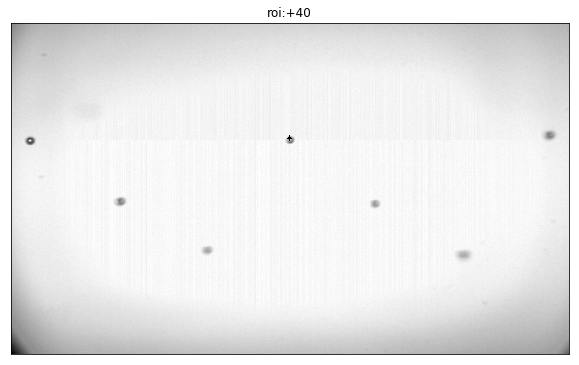

In [37]:
plot_list = []
k = "+40"
img = cv2.imread(imgs[k],cv2.IMREAD_ANYDEPTH)
rows,cols = img.shape
img16 = img[ int(rows/8):int(rows/2)-100, 0:cols  ]

img8 = convert16BitTo8Bit(img16)
histr = cv2.calcHist([img8],[0],None,[256],[0,256])
plt.plot(histr)


# plot_list.append((img8, "%s um" % (k)))

num_cols = 7
coi = 3    # 'column of interest', zero-based

roi = findROI(img8, num_cols, coi, tag=k, debug=True)


Finding ROI for img +0
Finding ROI for img +10
Finding ROI for img +20
Finding ROI for img +30
Finding ROI for img +40
Finding ROI for img -10
Finding ROI for img -20
Finding ROI for img -30
Finding ROI for img -40
Found 9 ROIs


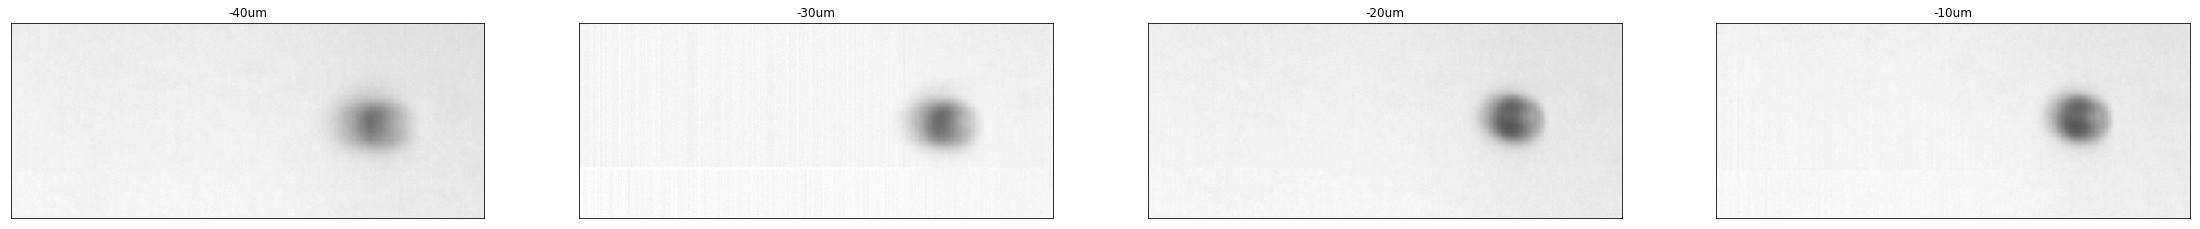

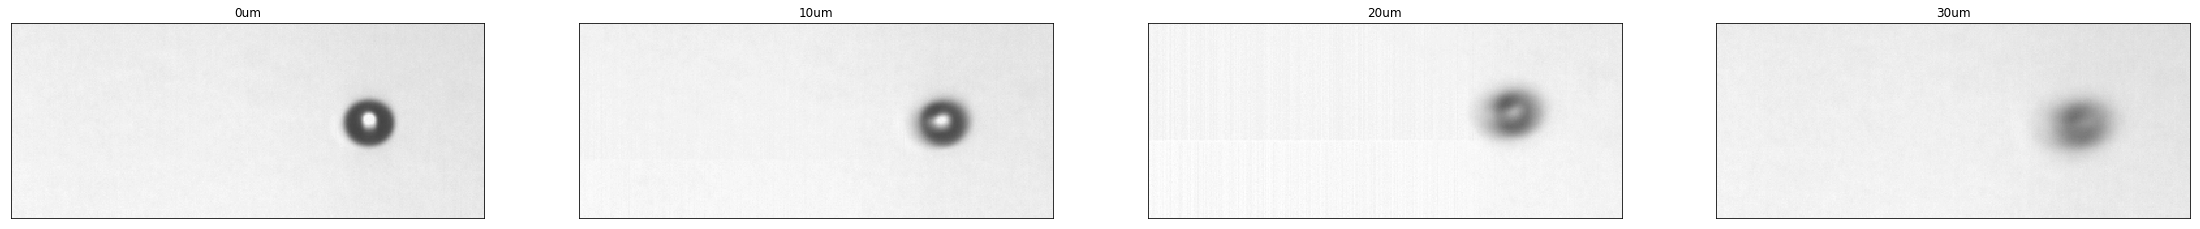

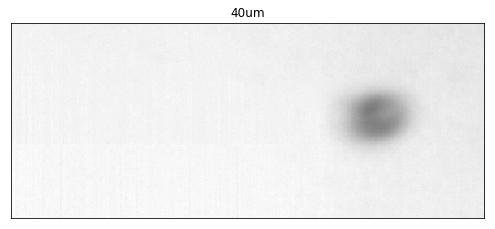

In [30]:
img_list = []
plot_list = []

num_cols = 7
coi = 6   # 'column of interest', zero-based

for k,v in imgs.items():
    print("Finding ROI for img %s" % (k))
    #img16 = cv2.imread(imgs[k],cv2.IMREAD_ANYDEPTH)

    img = cv2.imread(imgs[k],cv2.IMREAD_ANYDEPTH)
    rows,cols = img.shape
    img16 = img[ int(rows/8):int(rows/2)-100, 0:cols  ]
    rows,cols = img16.shape

    img8 = convert16BitTo8Bit(img16)
    cv2.putText(img8, k, (50, 50), cv2.FONT_HERSHEY_DUPLEX, 2, (255,255,255), 1)

    roi = findROI(img8, num_cols, coi, tag=k, debug=False)
    if roi is not None:
        img_list.append( (roi, int(k)) )
                
img_list = sorted(img_list, key=lambda x: x[1])

for img in img_list:
    plot_list.append( ( img[0], "%dum" % (int(img[1])) ) )

print("Found %d ROIs" % len(img_list))

util.plot_imgs(plot_list, max_cols = 4)

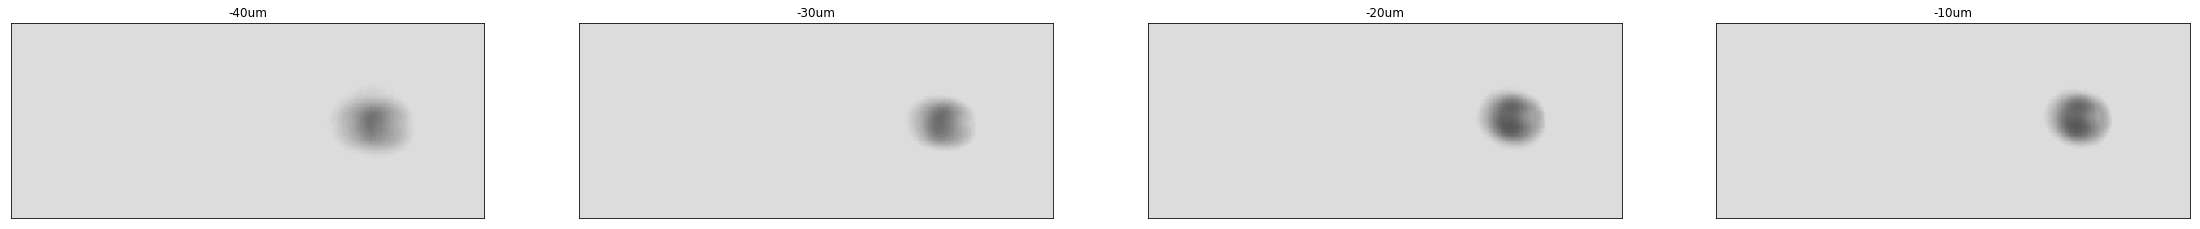

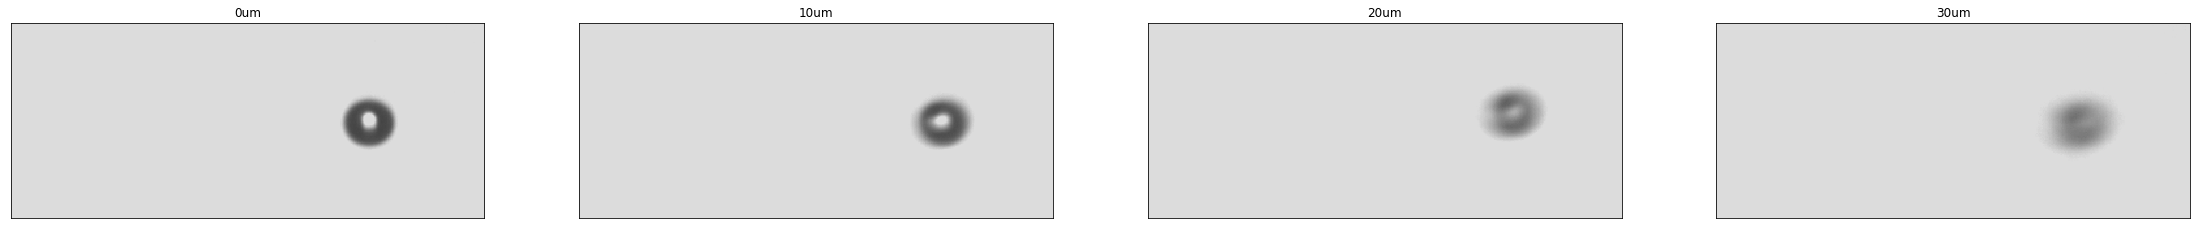

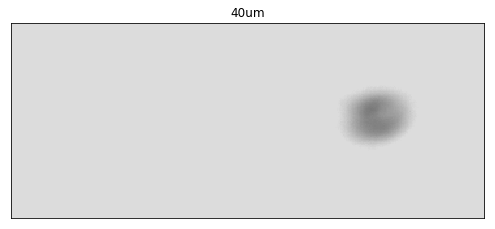

In [31]:
thresh_img_list = []
plot_list = []

for img in img_list:
    ret, roi_thresh = cv2.threshold(img[0], 220, 255, cv2.THRESH_TRUNC) 
    thresh_img_list.append( (roi_thresh, int(img[1])) )
    plot_list.append( ( roi_thresh, "%dum" % (int(img[1])) ) )

thresh_img_list = sorted(thresh_img_list, key=lambda x: x[1])
util.plot_imgs(plot_list, max_cols = 4)

## Test 1: Use the 'variation of the Laplacian' technique

Basically, take the Laplacian (2nd derivitive of image:  highlights regions of an image containing rapid intensity changes) of the image by running the following kernel over entire image:

$\begin{bmatrix}0 & 1 & 0\\1 & -4 & 1\\0 & 1 & 0\end{bmatrix}$

Then, take the variance of the Laplacian.  If an image contains high variance then there is a wide spread of responses, both edge-like and non-edge like, representative of a normal, in-focus image. But if there is very low variance, then there is a tiny spread of responses, indicating there are very little edges in the image. As we know, the more an image is blurred, the less edges there are.



-40um:      31621
-30um:      48841
-20um:      81456
-10um:      89027
 +0um:    1128788
+10um:     479607
+20um:     125315
+30um:      43001
+40um:      40074


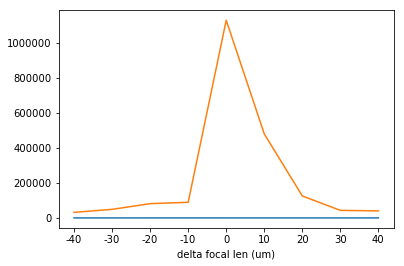

In [32]:
results = []
plot_list = []
ksize=7

# img_list contains list of tuples: (img, 'name')
for img in thresh_img_list:
    # Calc Laplacian of image
    lap_img = cv2.Laplacian(img[0], cv2.CV_64F, ksize=ksize)
    # Cal variance of Laplacian
    focus_measure = lap_img.var()
    plot_list.append( ((lap_img), "%dum: %d" % (img[1], int(focus_measure)) ) )
    results.append( (img[1], int(focus_measure)) )
    print("%+ 3dum: % 10d" % (img[1], int(focus_measure)))

plt.plot(results)
x_labels = [i[0] for i in results]
plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel('delta focal len (um)')
plt.show()
#util.plot_imgs(plot_list, max_cols = 2)

## Test 2: Use Canny, contours and moments to find feature loc, area, then sort based on area


In [ ]:
results = []
plot_list = []
ksize=7

# img_list contains list of tuples: (img, 'name')
for img in thresh_img_list:
    # Calc Canny of img
    #canny_output = cv2.Canny(img[0], 50, 100, apertureSize=3, L2gradient=True)
    canny_output = cv2.Canny(img[0], 250, 255, apertureSize=3, L2gradient=True)
    
    
#     sobelX = cv2.Sobel(img[0],cv2.CV_64F, 1, 0, ksize=3)
#     sobelX = np.uint8(np.absolute(sobelX))
#     sobelY = cv2.Sobel(img[0],cv2.CV_64F, 0, 1, ksize=3)
#     sobelY = np.uint8(np.absolute(sobelY))
#     sobelCombined = cv2.bitwise_or(sobelX, sobelY)

    plot_list.append( (canny_output,"%dum" % (img[1])) )
    continue
    
    # Find contours
    contour_img, contours, hierarchy = cv2.findContours(canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Get the moments
    mu_lst = []
    for contour in contours:
        mu = cv2.moments(contour, False)
        mu_lst.append(mu)

    #vector<Point2f> mc( contours.size() );
    mc_lst = []
    for i, contour in enumerate(contours):
        mu = mu_lst[i]
        mc = ( (mu['m10']/mu['m00']), (mu['m01']/mu['m00']) )
        print( mc)
        mc_lst.append(mc)

    # Draw contours
    #Mat drawing = Mat::zeros( canny_output.size(), CV_8UC3 );
    rows,cols = img[0].shape
    drawing  = np.zeros((rows, cols, 3), np.uint8)
    for i, contour in enumerate(contours):
        cv2.drawContours( drawing, contours, i, (128,255,255), 3, cv2.LINE_AA, hierarchy, 0 )
        cp = (int(mc_lst[i][0]), int(mc_lst[i][1]) )
        cv2.circle(drawing, cp, 4, (255,0,0),4)    

    if len(contours) > 0:
        #Calculate the area with the moments 00 and compare with the result of the OpenCV function
        print("Info: Area and Contour Length");
        for i, contour in enumerate(contours):
            area = cv2.contourArea(contour)
            arc_length = cv2.arcLength( contour, True )
            print(" * Contour[%d] - Area (M_00) = %.2f - Area OpenCV: %.2f - Length: %.2f" % (i, mu_lst[i]['m00'], area, arc_length) )

        plot_list.append( (drawing,"%dum: %d" % (img[1], int(area))) )
        results.append( (img[1], int(area)) )
        print("%dum: %d" % (img[1], int(area)))
    else:
        print("No contours found for %dum" % (img[1]) )

plt.plot(results)
x_labels = [i[0] for i in results]
plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel('delta focal len (um)')
plt.show()
util.plot_imgs(plot_list, max_cols = 2)